In [7]:
import os
import sys
import numpy
import json
import subprocess
import isambard_dev
import operator
import matplotlib.pyplot as plt
%matplotlib notebook

Import modules to get methods for interaction analysis

In [8]:
new_module = "/home/ba13026/mpmodeling/analysis/"
if new_module not in sys.path:
    sys.path.append(new_module)

In [9]:
from insert2db_interactions import get_OH_atoms
from insert2db_interactions import get_KIHs
from insert2db_interactions import interaction_direction
import json

Make list of paths to MD data for all docked models of cWza mutants

In [62]:
mutant_paths = [
    "/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwza_NoWPN/3-analysis/md_relax/sem",
    "/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwzay373c_NoWPN/3-analysis/md_relax",
    "/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwzak375c_NoWPN/3-analysis/md_relax",
    "/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwzas355c_NoWPN/3-analysis/md_relax",
]

mutant_names = ['cWza','cWza-Y373C','cWza-K375C','cWza-S355C']

Check all files correctly in place

Make data structure

In [33]:
mutant_interaction_data = {}
for mutant in mutant_names:
    mutant_interaction_data[mutant] = {}
    for interaction_type in ['hbonds','kihs']:
        mutant_interaction_data[mutant][interaction_type] = {}

Store all data in dictionary

In [35]:
for i in range(len(mutant_paths)):
    for interaction_type in ['hbonds','kihs']:
        if interaction_type == 'hbonds':
            json_file = 'Hbonds_Original_PostEM.json'
        elif interaction_type == 'kihs':
            json_file = 'KIHs_Original_PostEM.json'
        full_path = mutant_paths[i]+'/'+json_file
        with open(full_path,'r') as x:
            mutant_interaction_data[mutant_names[i]][interaction_type] = json.load(x)

Generate super-set of base **H-bond HO-** and **KIH-atoms**:

In [167]:
S = {}
S['hbonds'] = set()
S['kihs'] = set()

for i in range(len(mutant_paths)):
    for interaction_type in ['hbonds','kihs']:
        data = mutant_interaction_data[mutant_names[i]][interaction_type]
        for group in ["wide","narrow"]:
            for pdb in list(data[group].keys()):
                for type in ["original","em"]:
                    if data[group][pdb][type] != "NoFile":
                        S[interaction_type] =  S[interaction_type].union(data[group][pdb][type])

In [168]:
for interaction_type in ['hbonds','kihs']:
    X = S[interaction_type]
    Y = [json.dumps(x[:-1]+[interaction_direction(x[-1])]) for x in [json.loads(x) for x in list(X)]]
    S_ordered = []
    for resn in range(1,33):
        for y in set(Y):
            x = json.loads(y)
            if int(x[0]) == resn:
                S_ordered.append(json.dumps(x))
    S[interaction_type] = S_ordered

Determine **statistics per interaction type**

In [92]:
mutant_interaction_stats = {}

for mutant in mutant_names:
    mutant_interaction_stats[mutant] = {}
    for interaction_type in ['hbonds','kihs']:        
        mutant_interaction_stats[mutant][interaction_type] = {}
        for group in ["narrow","wide"]:
            mutant_interaction_stats[mutant][interaction_type][group] = {}
            data = mutant_interaction_data[mutant][interaction_type][group]
            for pdb in list(data.keys()):
                mutant_interaction_stats[mutant][interaction_type][group][pdb] = {}
                for type in ["original","em"]:
                    decomposition_vector = []
                    if data[pdb]["em"] != "NoFile":
                        for s in S[interaction_type]:
                            counter = 0
                            for x in data[pdb][type]:
                                x_raw = json.loads(x)
                                y = json.dumps(x_raw[:-1]+[interaction_direction(x_raw[-1])])
                                if y == s:
                                    counter +=1
                            decomposition_vector.append(counter)
                        mutant_interaction_stats[mutant][interaction_type][group][pdb][type] = decomposition_vector
                    else:
                        for type in ["original","em"]:
                            mutant_interaction_stats[mutant][interaction_type][group][pdb][type] = "NA"     

Save stats in JSON file

In [93]:
mypath = "/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test"
with open(mypath+'/'+'mutant_interaction_stats.json','w') as fp:
    json.dump(mutant_interaction_stats, fp, sort_keys=True, indent=4)

**Data reduction** for data visualization

All the interactions whose probability is lower than 0.5% will be discarded.

In [303]:
N_chains = 8
probability_data_raw = {}
labels = {}
for interaction_type in ['hbonds','kihs']:
    probability_data_raw[interaction_type] = []
    labels[interaction_type] = []
    Sx = S[interaction_type]
    for mutant in mutant_names:
        for group in ['narrow','wide']:
            data = mutant_interaction_stats[mutant][interaction_type][group]
            for mtype in ['original','em']:
                N_models = 0
                X = numpy.zeros(len(Sx))
                for pdb in list(data.keys()):
                    x = data[pdb][mtype]
                    if x != 'NA':
                        X = X + numpy.asarray(x)
                        N_models += 1
                probability = X/float(N_chains*N_models)
                labels[interaction_type].append([mutant,group,mtype])
                probability_data_raw[interaction_type].append(probability)

In [304]:
S_refined = {}
for interaction_type in ['hbonds','kihs']:
    Sx = S[interaction_type]
    S_refined[interaction_type] = []
    data = numpy.array(probability_data_raw[interaction_type]).T
    tolerance = 0.05
    exclude = []
    for i in range(len(Sx)):
        comparison = data[i] >= tolerance
        if any(comparison):
            exclude.append(i)
    extracted_data = operator.itemgetter(*exclude)(data)
    probability_data_refined[interaction_type] = numpy.asarray(extracted_data).T
    S_refined[interaction_type] = operator.itemgetter(*exclude)(Sx)

<h1 style="text-align:center">Comparing all data</h1> 

<h2 style="text-align:center">Narrow Vs. Wide: Original docked models</h2> 

<IPython.core.display.Javascript object>


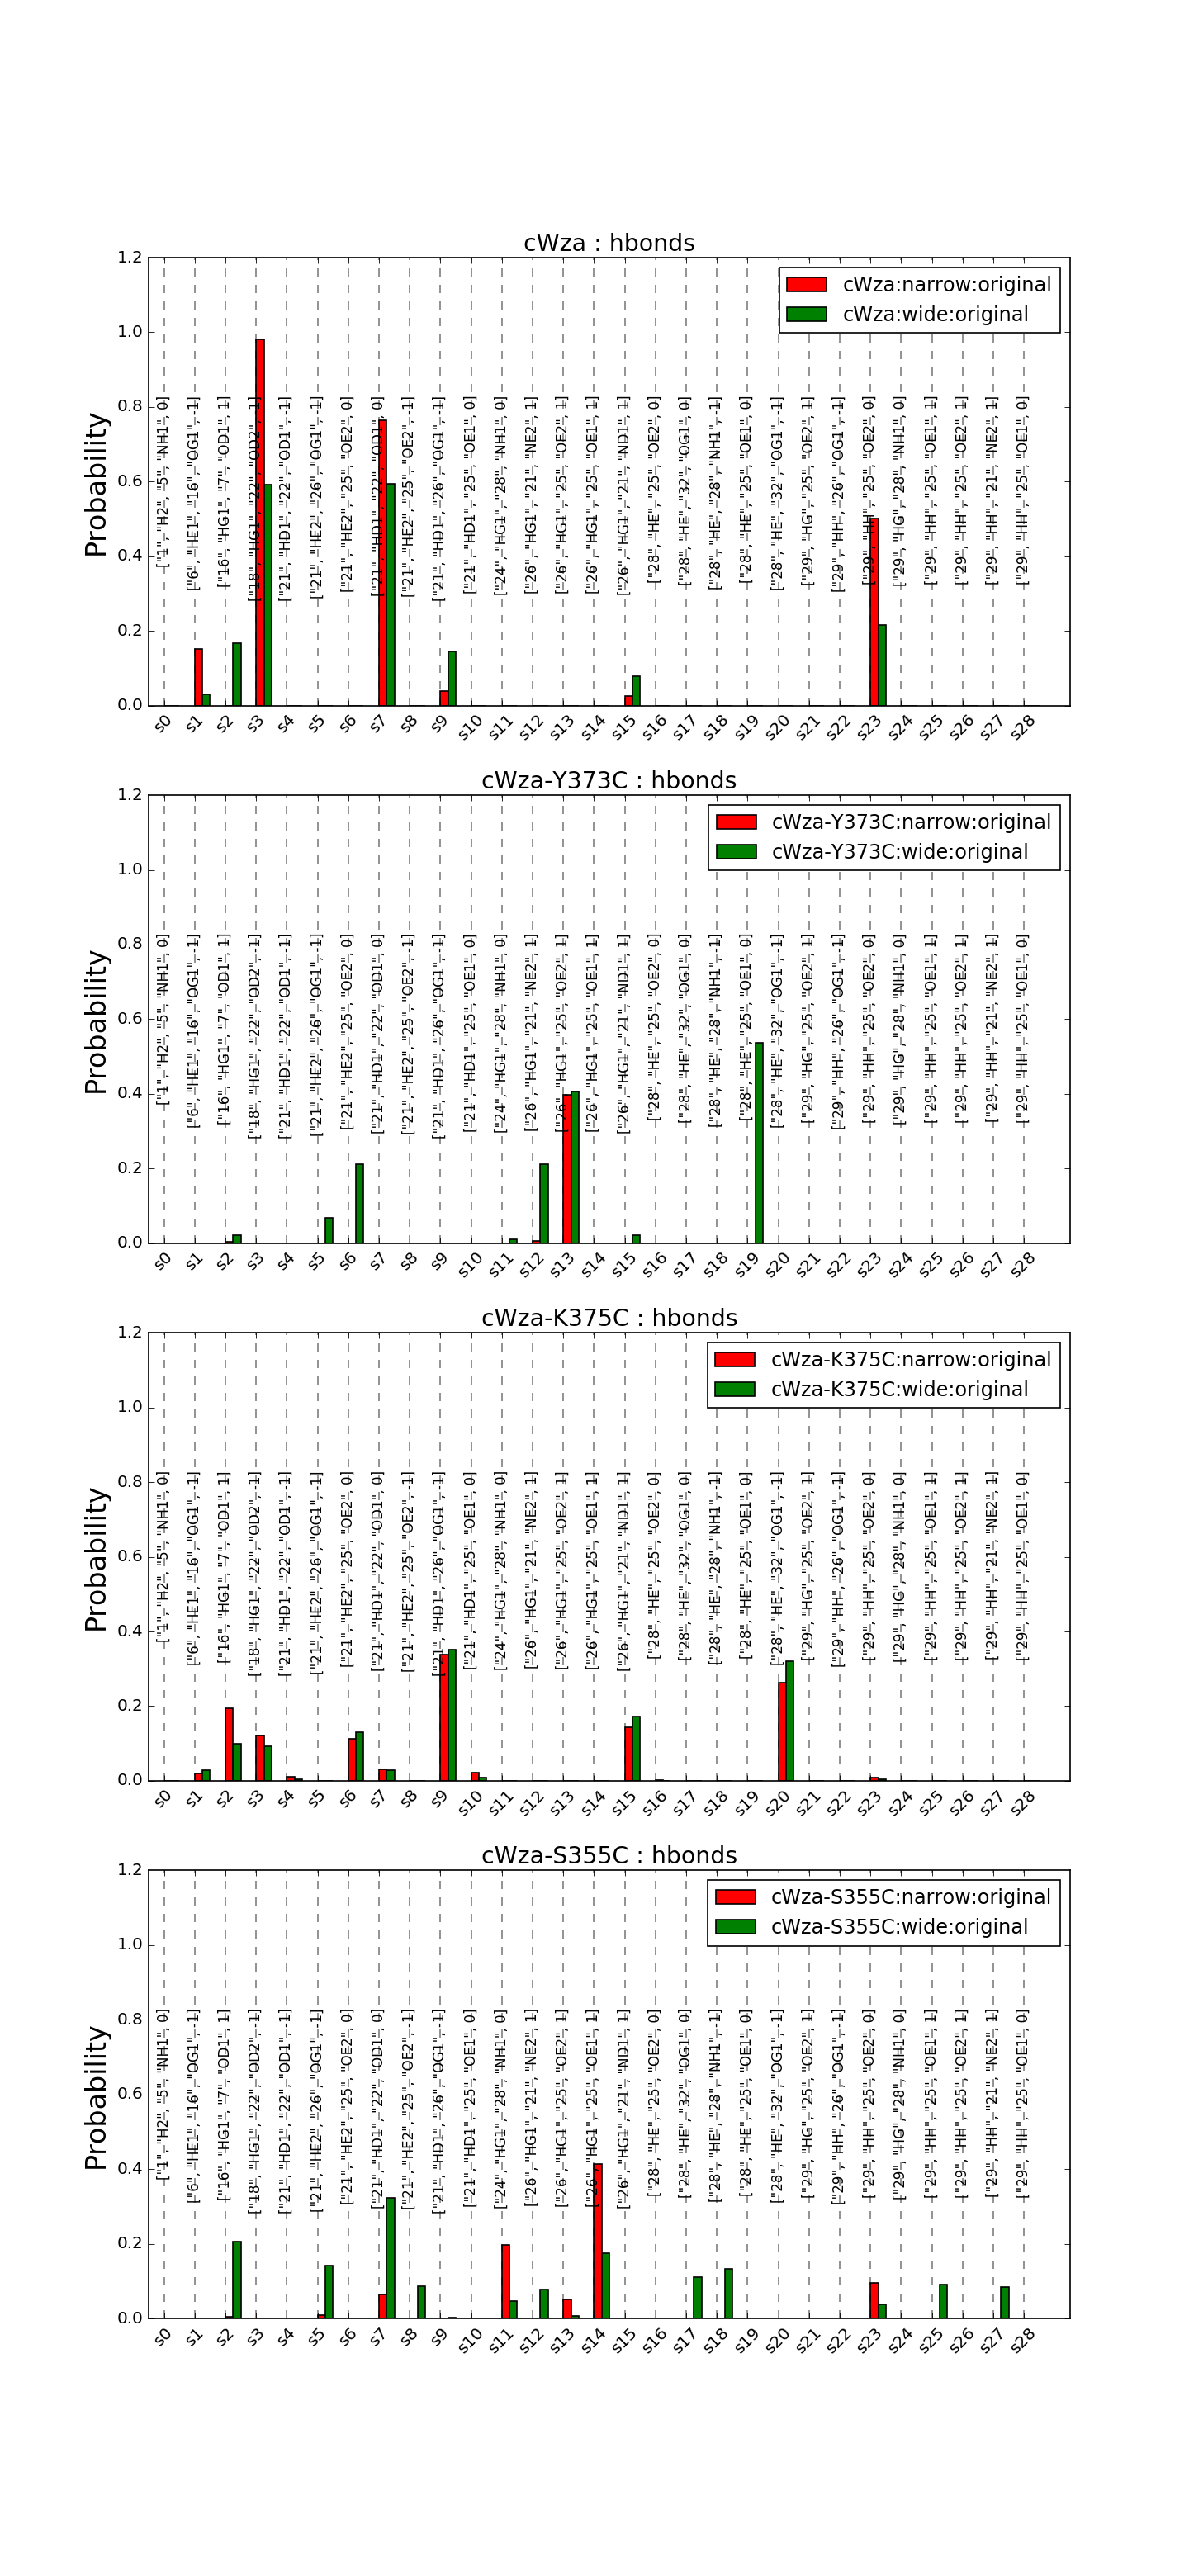

In [341]:
fig_hbonds,ax = plt.subplots(len(mutant_names),1,figsize=(12,26),dpi=120)

interaction_type = 'hbonds'
X = numpy.arange(len(S_refined[interaction_type]))
data = probability_data_refined[interaction_type]

for i in range(len(mutant_names)):
    index0 = 4*i
    Y0 = data[index0]
    ax[i].bar(X, Y0,label=":".join(labels[interaction_type][index0]),width=0.25,color='red')

    shift = 0.25
    index1 = index0+2
    Y1 = data[index1]
    ax[i].bar(X+shift, Y1,label=":".join(labels[interaction_type][index1]),width=0.25,color='green')
    
    ax[i].set_title(mutant_names[i]+" : "+interaction_type,fontsize=17)
    ax[i].set_xlim(-0.5,len(X)+0.5)
    ax[i].set_ylim(0,1.2)


    ax[i].set_xticks(X)
    ax[i].set_xticklabels(["s"+str(j) for j in range(len(X))],rotation=45)
    for k in range(len(X)):
        ax[i].plot((k,k),(0,1.2),color="black",linestyle="--",alpha=0.5)

    ax[i].set_ylabel("Probability",fontsize=20)
    
    for k in range(len(X)):
        ax[i].text(k-0.25,0.8,list(S_refined[interaction_type])[k],fontsize=10,rotation=90)

    ax[i].legend(loc="best")
        
plt.show()

<IPython.core.display.Javascript object>


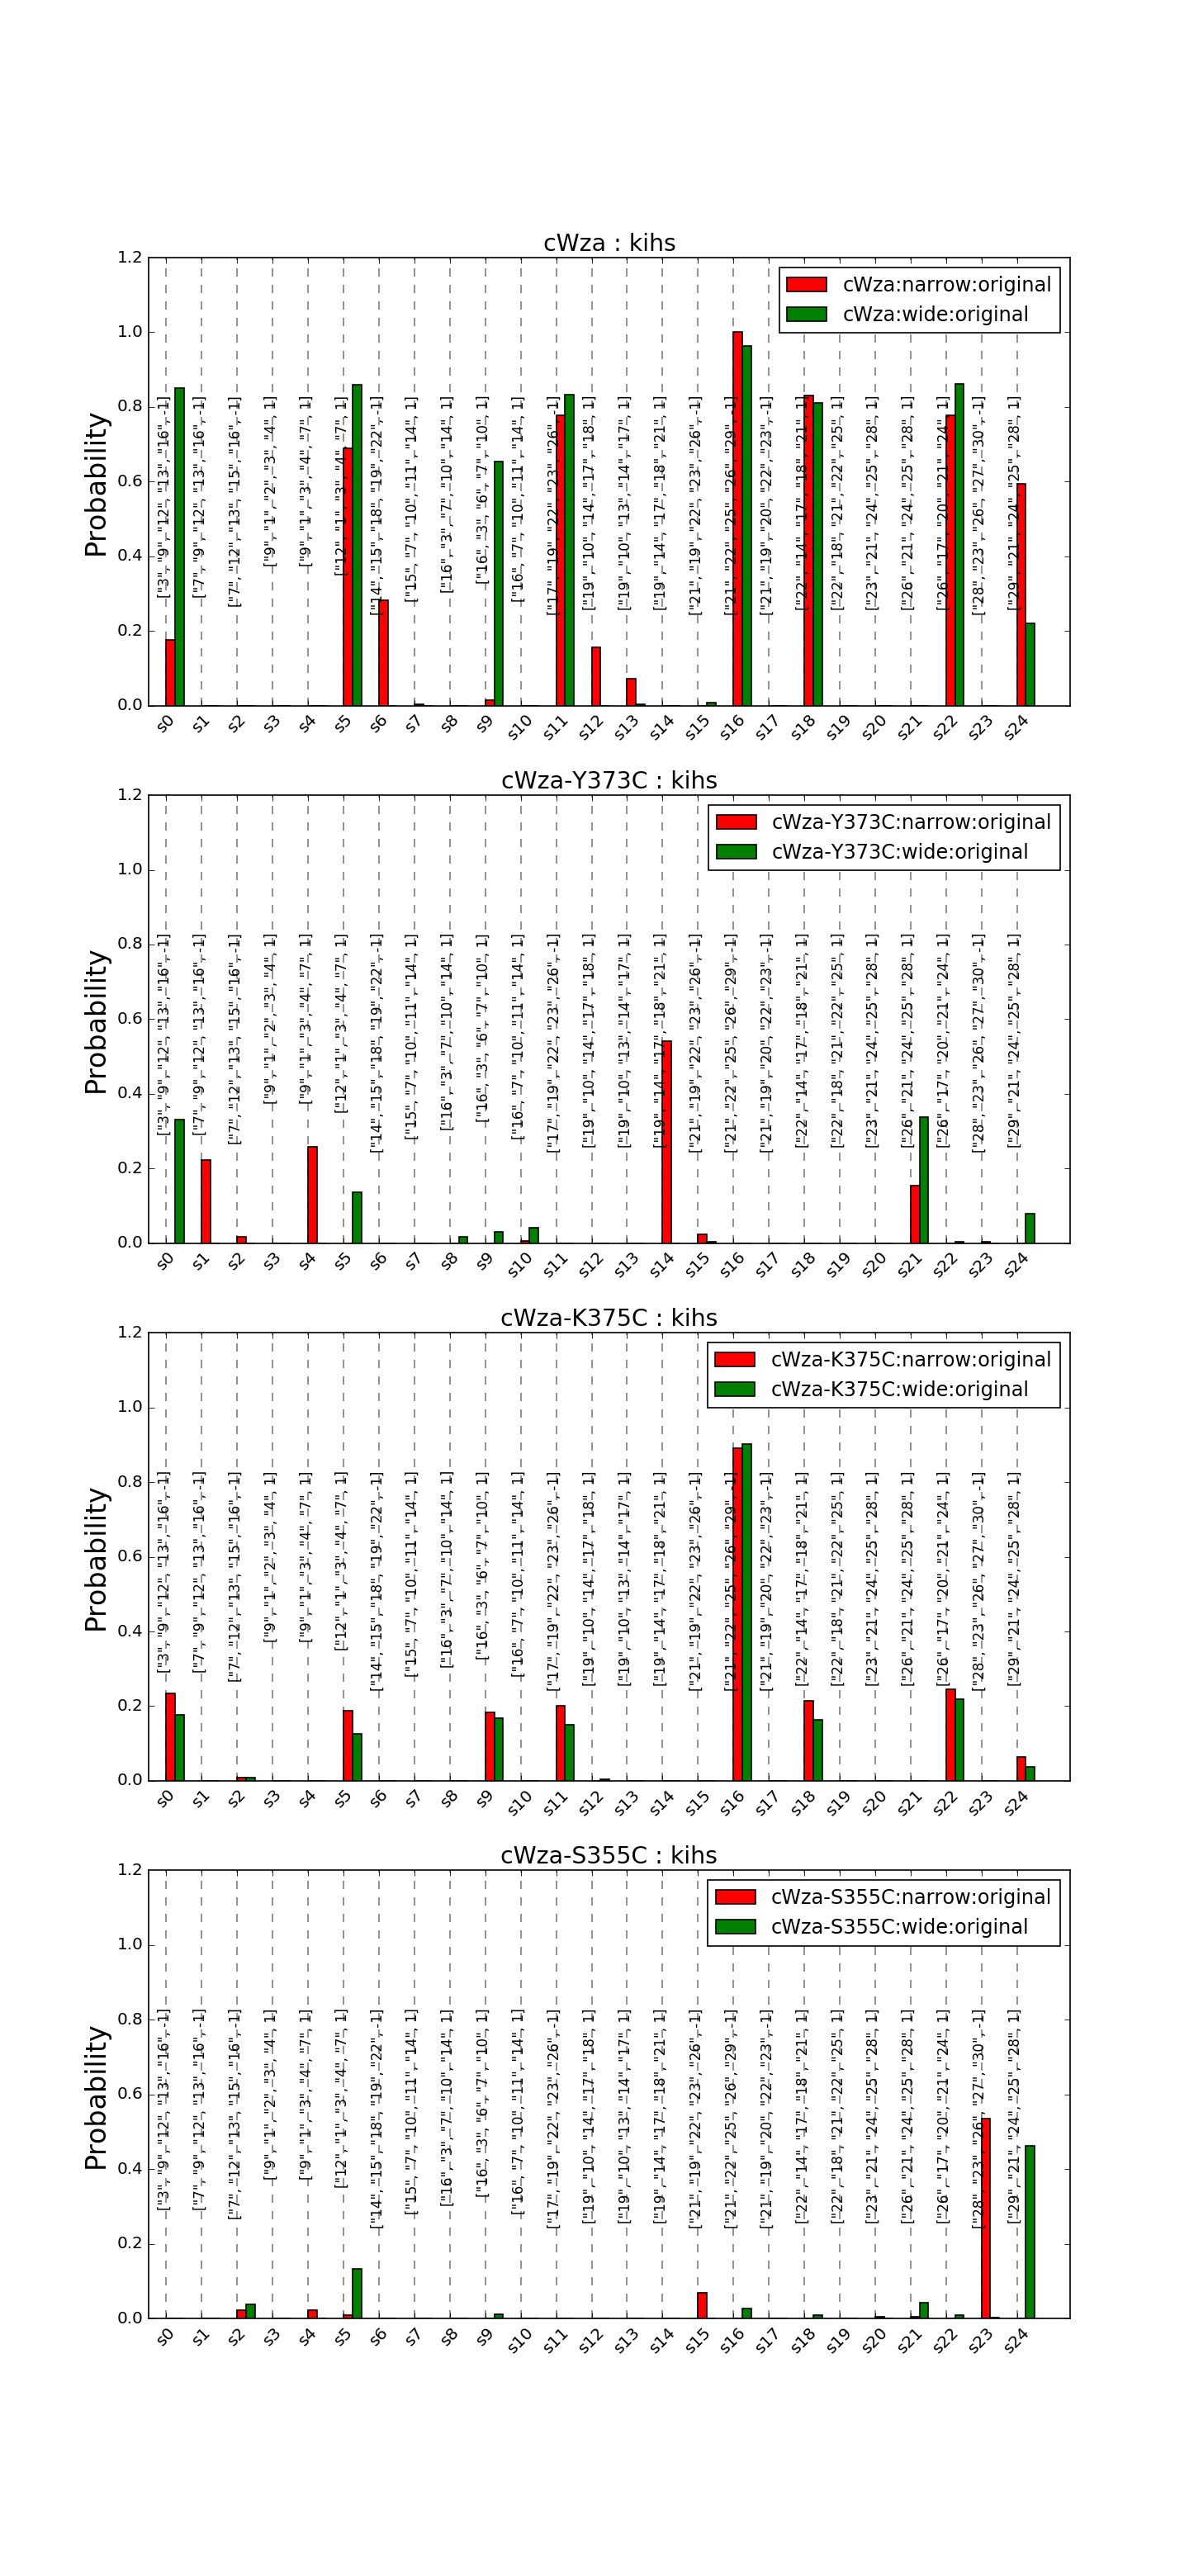

In [342]:
fig_hbonds,ax = plt.subplots(len(mutant_names),1,figsize=(12,26),dpi=120)

interaction_type = 'kihs'
X = numpy.arange(len(S_refined[interaction_type]))
data = probability_data_refined[interaction_type]

for i in range(len(mutant_names)):
    index0 = 4*i
    Y0 = data[index0]
    ax[i].bar(X, Y0,label=":".join(labels[interaction_type][index0]),width=0.25,color='red')

    shift = 0.25
    index1 = index0+2
    Y1 = data[index1]
    ax[i].bar(X+shift, Y1,label=":".join(labels[interaction_type][index1]),width=0.25,color='green')
    
    ax[i].set_title(mutant_names[i]+" : "+interaction_type,fontsize=17)
    ax[i].set_xlim(-0.5,len(X)+0.5)
    ax[i].set_ylim(0,1.2)


    ax[i].set_xticks(X)
    ax[i].set_xticklabels(["s"+str(j) for j in range(len(X))],rotation=45)
    for k in range(len(X)):
        ax[i].plot((k,k),(0,1.2),color="black",linestyle="--",alpha=0.5)

    ax[i].set_ylabel("Probability",fontsize=20)
    
    for k in range(len(X)):
        ax[i].text(k-0.25,0.8,list(S_refined[interaction_type])[k],fontsize=10,rotation=90)

    ax[i].legend(loc="best")
        
plt.show()

<h2 style="text-align:center">Original docked models Vs. Energy minimised</h2> 
<h3 style="text-align:center">Hydrogen bonds</h3> 


<IPython.core.display.Javascript object>


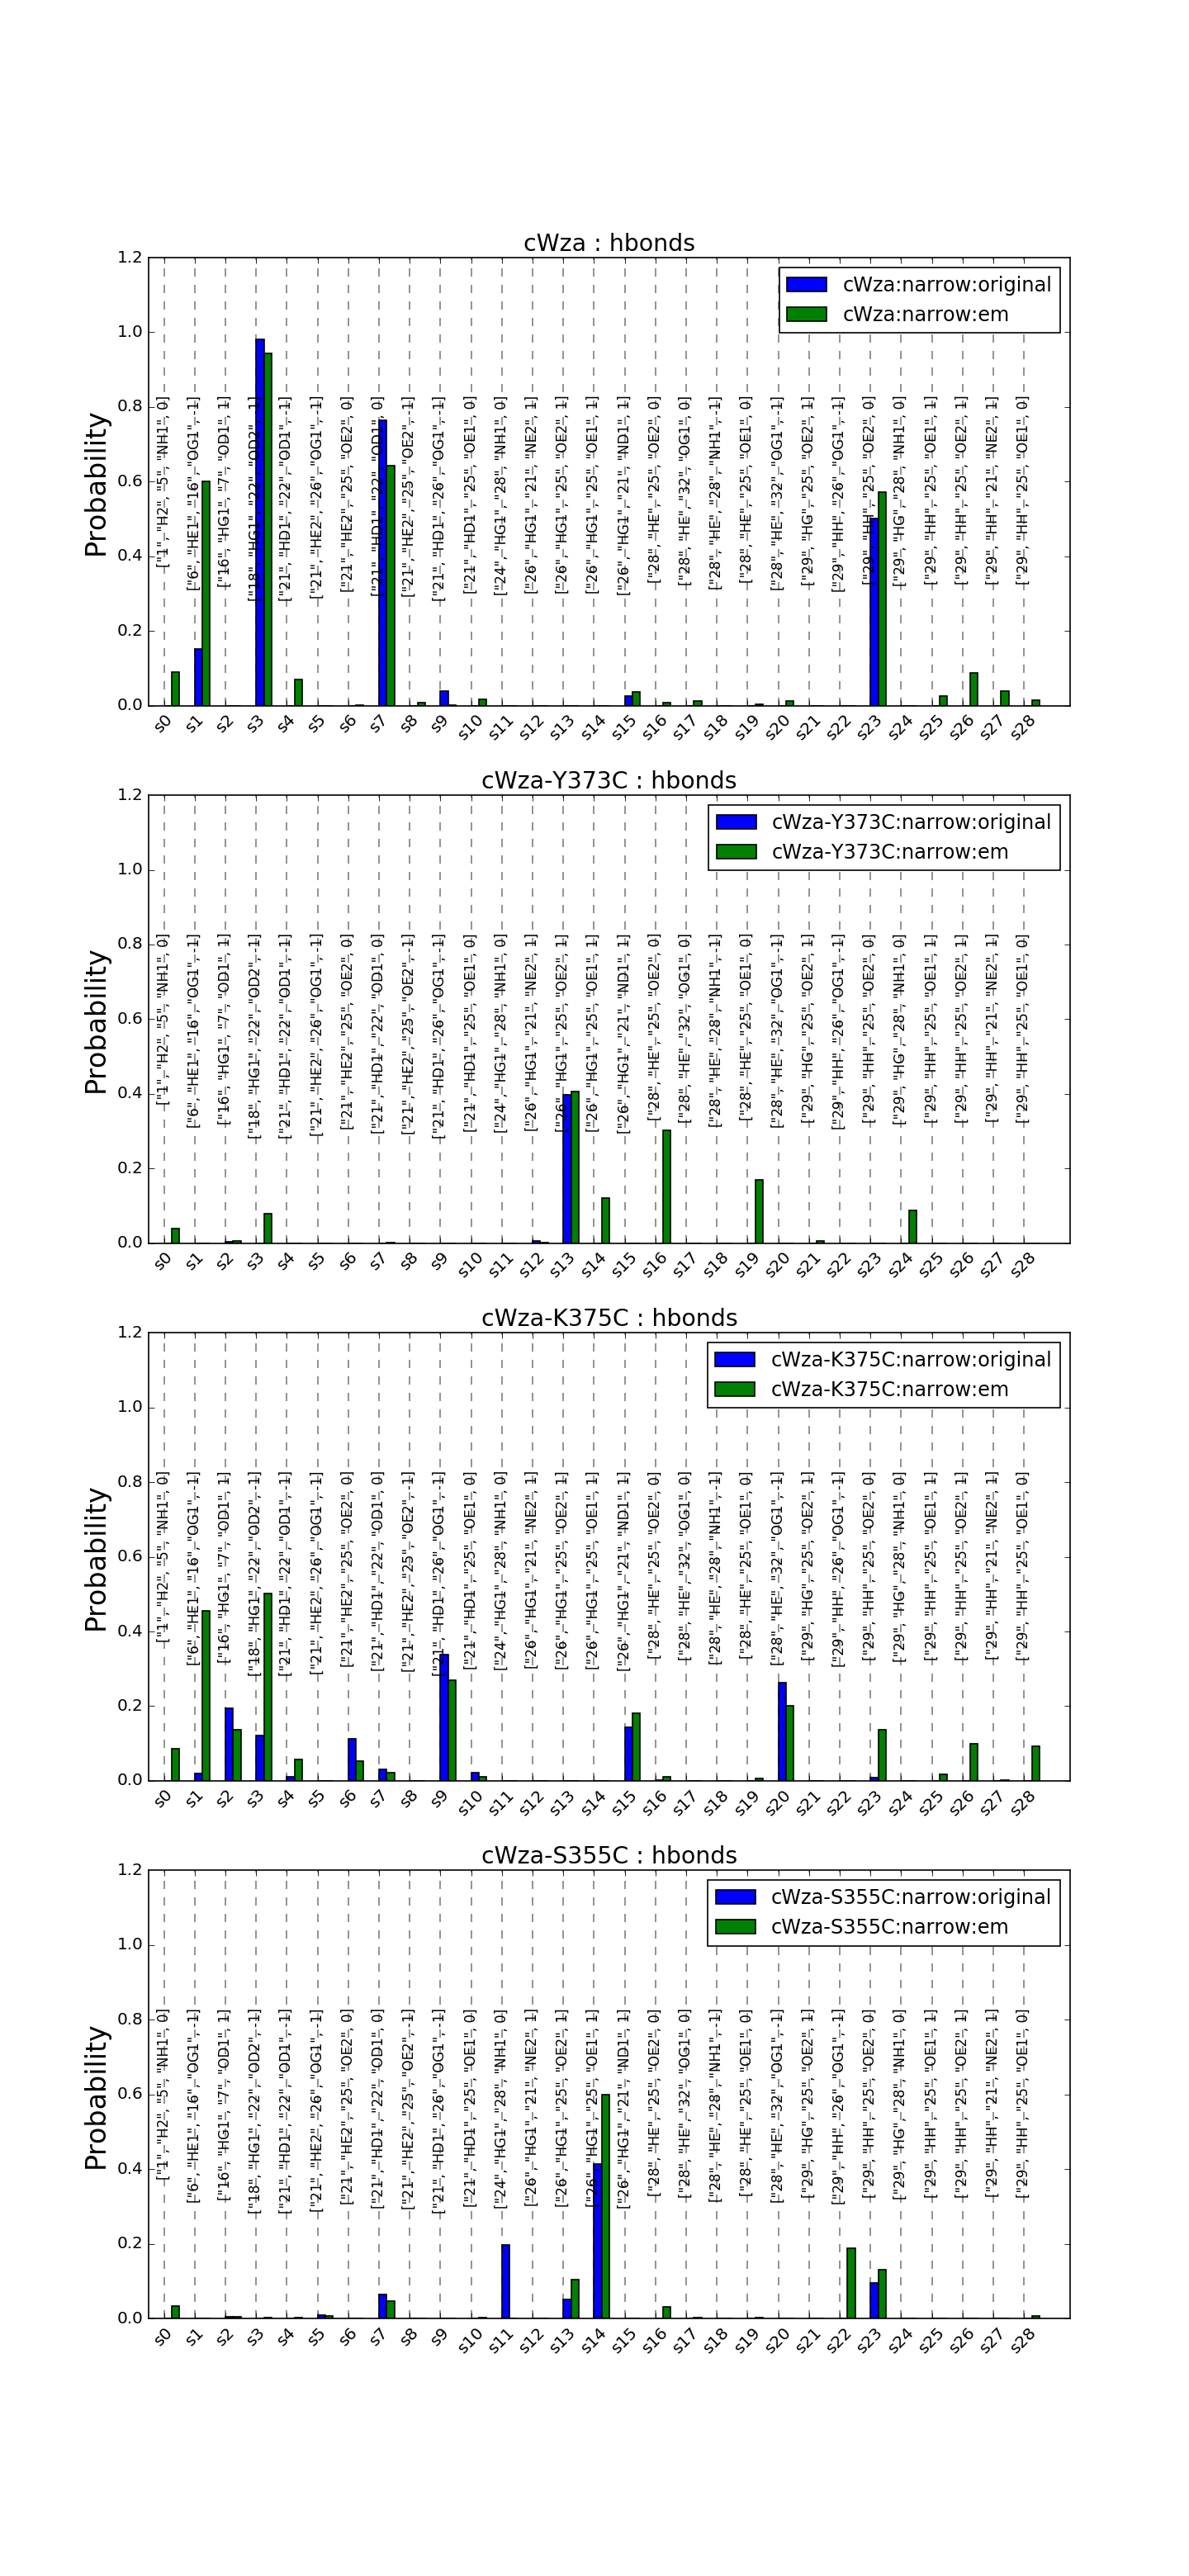

In [351]:
fig_hbonds,ax = plt.subplots(len(mutant_names),1,figsize=(12,26),dpi=120)

interaction_type = 'hbonds'
X = numpy.arange(len(S_refined[interaction_type]))
data = probability_data_refined[interaction_type]

for i in range(len(mutant_names)):
    index0 = 4*i
    Y0 = data[index0]
    ax[i].bar(X, Y0,label=":".join(labels[interaction_type][index0]),width=0.25,color='blue')

    shift = 0.25
    index1 = index0+1
    Y1 = data[index1]
    ax[i].bar(X+shift, Y1,label=":".join(labels[interaction_type][index1]),width=0.25,color='green')
    
    ax[i].set_title(mutant_names[i]+" : "+interaction_type,fontsize=17)
    ax[i].set_xlim(-0.5,len(X)+0.5)
    ax[i].set_ylim(0,1.2)


    ax[i].set_xticks(X)
    ax[i].set_xticklabels(["s"+str(j) for j in range(len(X))],rotation=45)
    for k in range(len(X)):
        ax[i].plot((k,k),(0,1.2),color="black",linestyle="--",alpha=0.5)

    ax[i].set_ylabel("Probability",fontsize=20)
    
    for k in range(len(X)):
        ax[i].text(k-0.25,0.8,list(S_refined[interaction_type])[k],fontsize=10,rotation=90)

    ax[i].legend(loc="best")
        
plt.show()

<IPython.core.display.Javascript object>


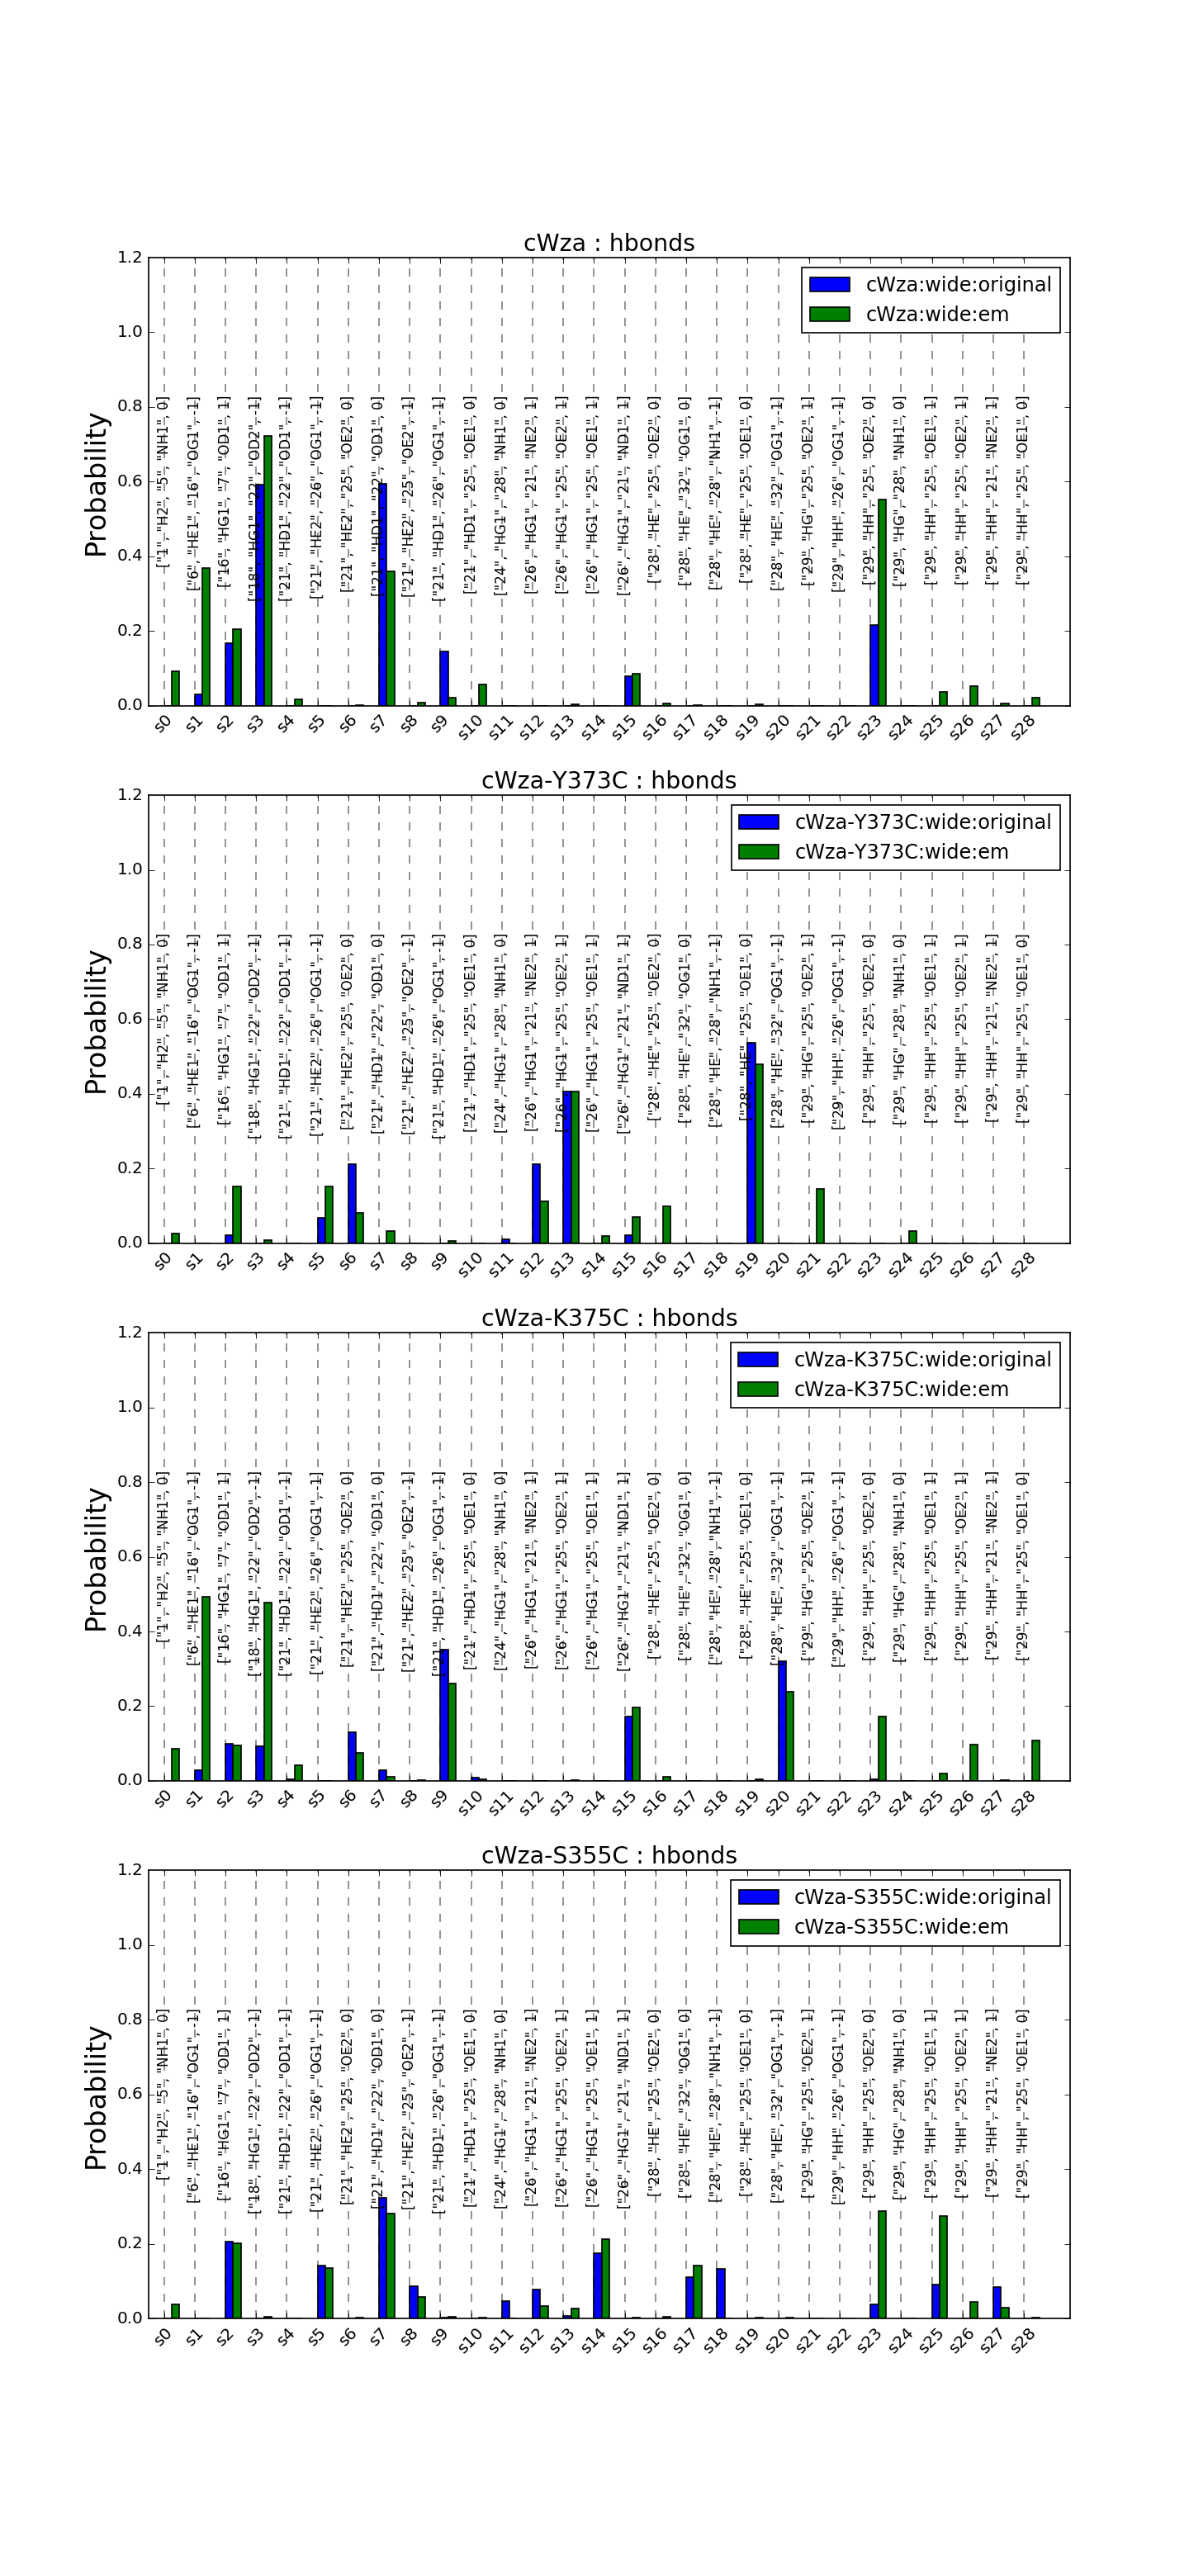

In [352]:
fig_hbonds,ax = plt.subplots(len(mutant_names),1,figsize=(12,26),dpi=120)

interaction_type = 'hbonds'
X = numpy.arange(len(S_refined[interaction_type]))
data = probability_data_refined[interaction_type]

for i in range(len(mutant_names)):
    index0 = 4*i+2
    Y0 = data[index0]
    ax[i].bar(X, Y0,label=":".join(labels[interaction_type][index0]),width=0.25,color='blue')

    shift = 0.25
    index1 = index0+1
    Y1 = data[index1]
    ax[i].bar(X+shift, Y1,label=":".join(labels[interaction_type][index1]),width=0.25,color='green')
    
    ax[i].set_title(mutant_names[i]+" : "+interaction_type,fontsize=17)
    ax[i].set_xlim(-0.5,len(X)+0.5)
    ax[i].set_ylim(0,1.2)


    ax[i].set_xticks(X)
    ax[i].set_xticklabels(["s"+str(j) for j in range(len(X))],rotation=45)
    for k in range(len(X)):
        ax[i].plot((k,k),(0,1.2),color="black",linestyle="--",alpha=0.5)

    ax[i].set_ylabel("Probability",fontsize=20)
    
    for k in range(len(X)):
        ax[i].text(k-0.25,0.8,list(S_refined[interaction_type])[k],fontsize=10,rotation=90)

    ax[i].legend(loc="best")
        
plt.show()

<h2 style="text-align:center">Original docked models Vs. Energy minimised</h2> 
<h3 style="text-align:center">Knobs into Holes</h3> 


<IPython.core.display.Javascript object>


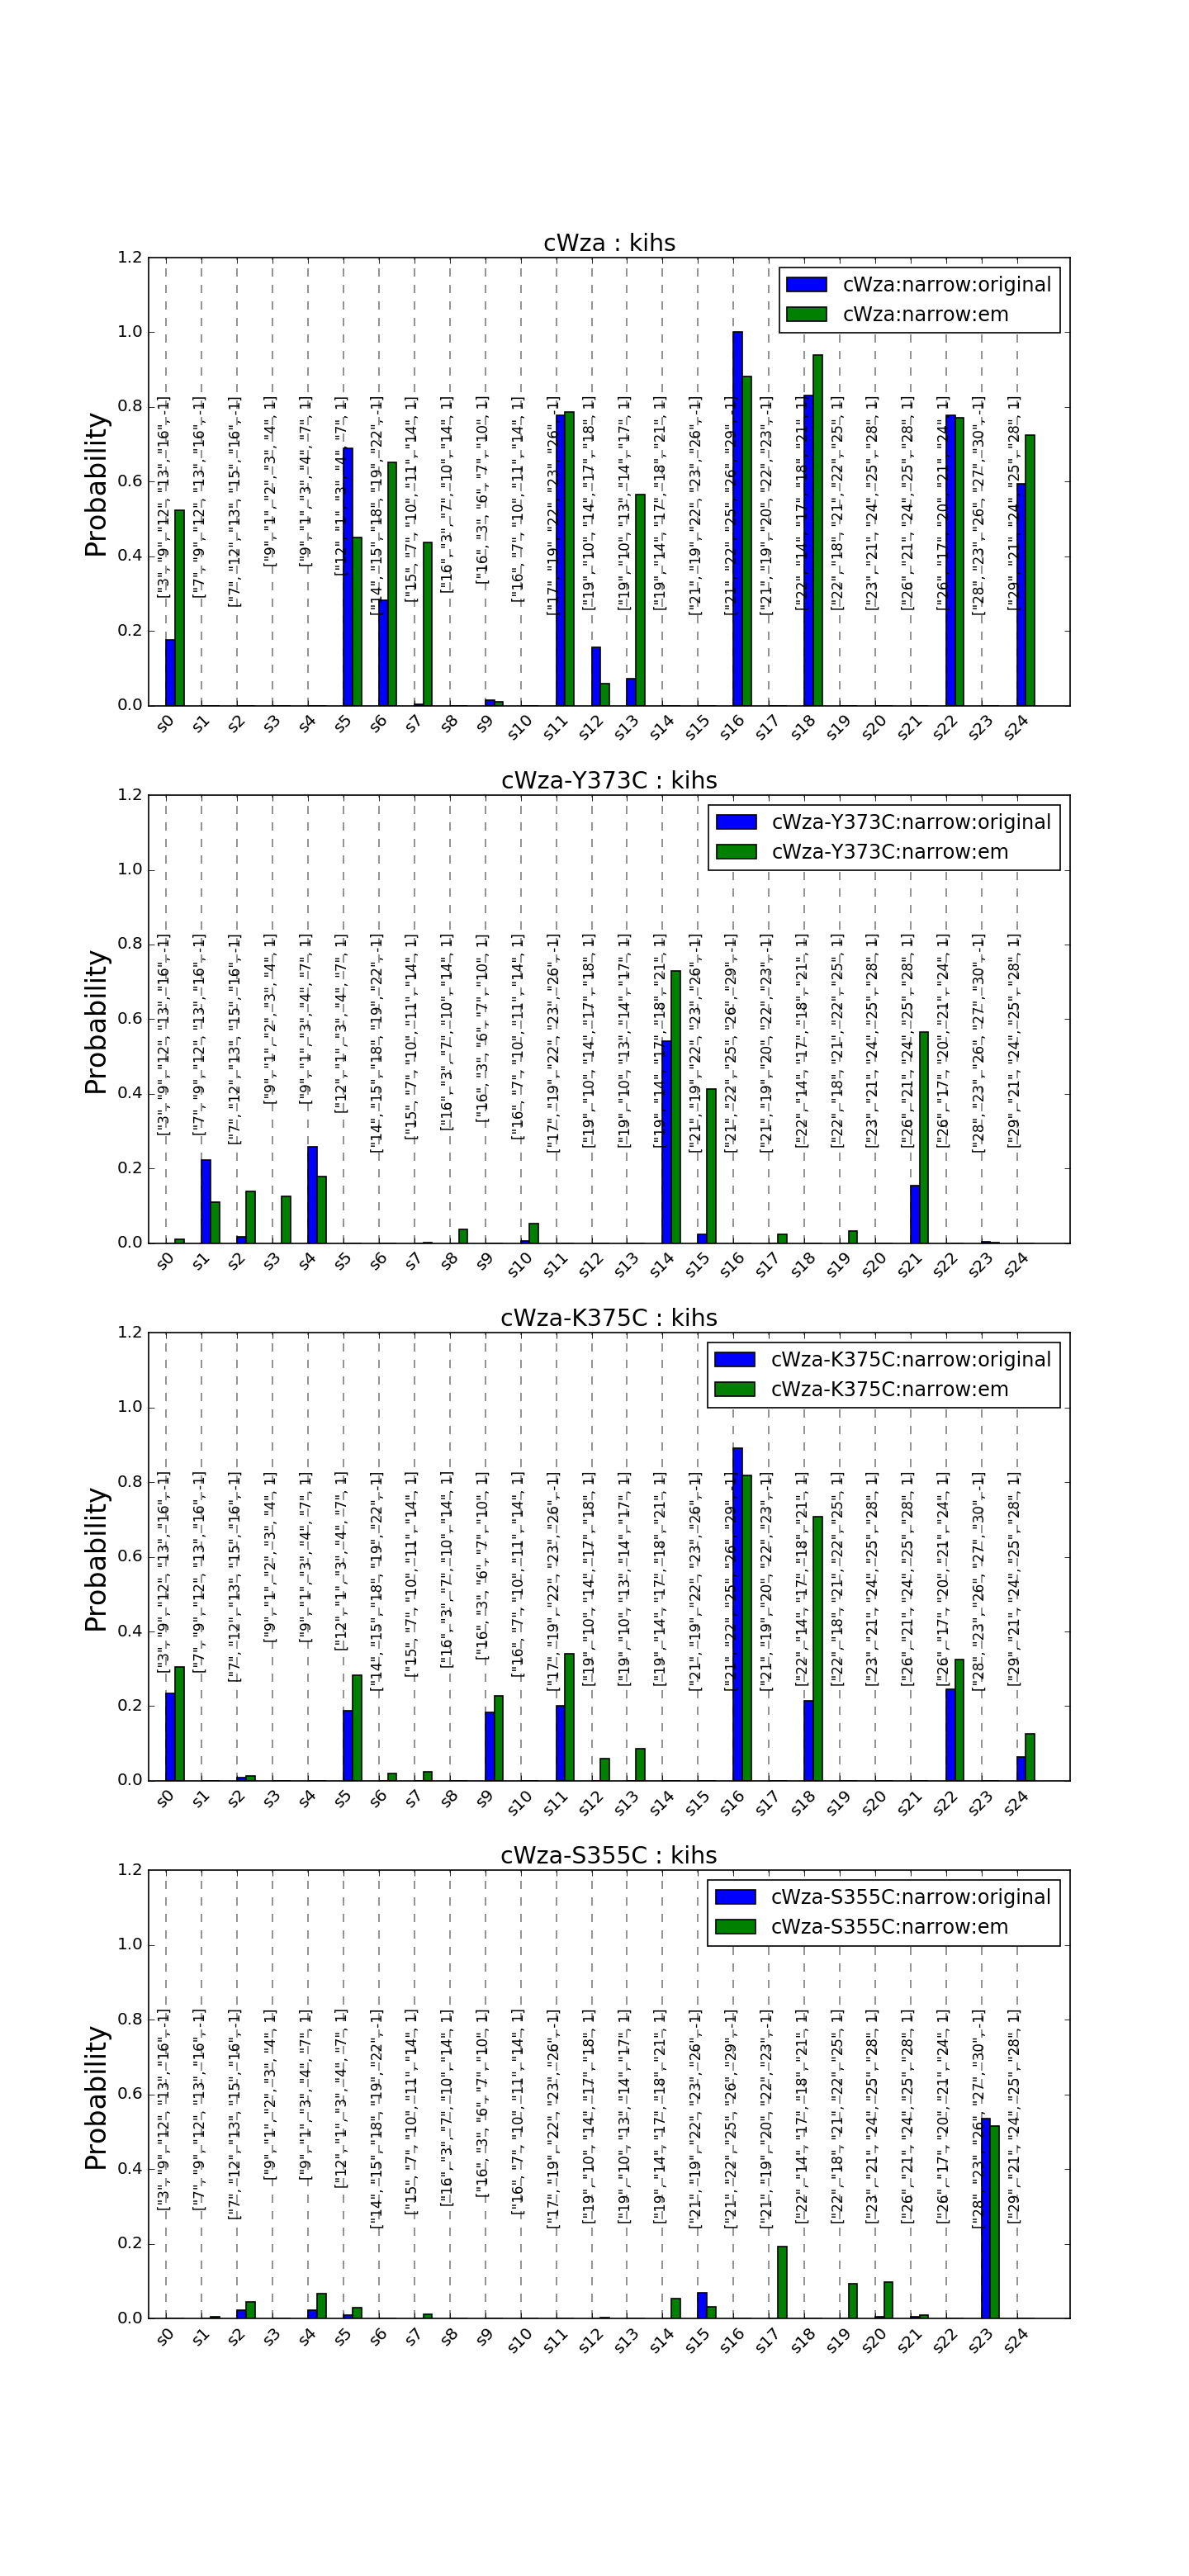

In [353]:
fig_hbonds,ax = plt.subplots(len(mutant_names),1,figsize=(12,26),dpi=120)

interaction_type = 'kihs'
X = numpy.arange(len(S_refined[interaction_type]))
data = probability_data_refined[interaction_type]

for i in range(len(mutant_names)):
    index0 = 4*i
    Y0 = data[index0]
    ax[i].bar(X, Y0,label=":".join(labels[interaction_type][index0]),width=0.25,color='blue')

    shift = 0.25
    index1 = index0+1
    Y1 = data[index1]
    ax[i].bar(X+shift, Y1,label=":".join(labels[interaction_type][index1]),width=0.25,color='green')
    
    ax[i].set_title(mutant_names[i]+" : "+interaction_type,fontsize=17)
    ax[i].set_xlim(-0.5,len(X)+0.5)
    ax[i].set_ylim(0,1.2)


    ax[i].set_xticks(X)
    ax[i].set_xticklabels(["s"+str(j) for j in range(len(X))],rotation=45)
    for k in range(len(X)):
        ax[i].plot((k,k),(0,1.2),color="black",linestyle="--",alpha=0.5)

    ax[i].set_ylabel("Probability",fontsize=20)
    
    for k in range(len(X)):
        ax[i].text(k-0.25,0.8,list(S_refined[interaction_type])[k],fontsize=10,rotation=90)

    ax[i].legend(loc="best")
        
plt.show()

<IPython.core.display.Javascript object>


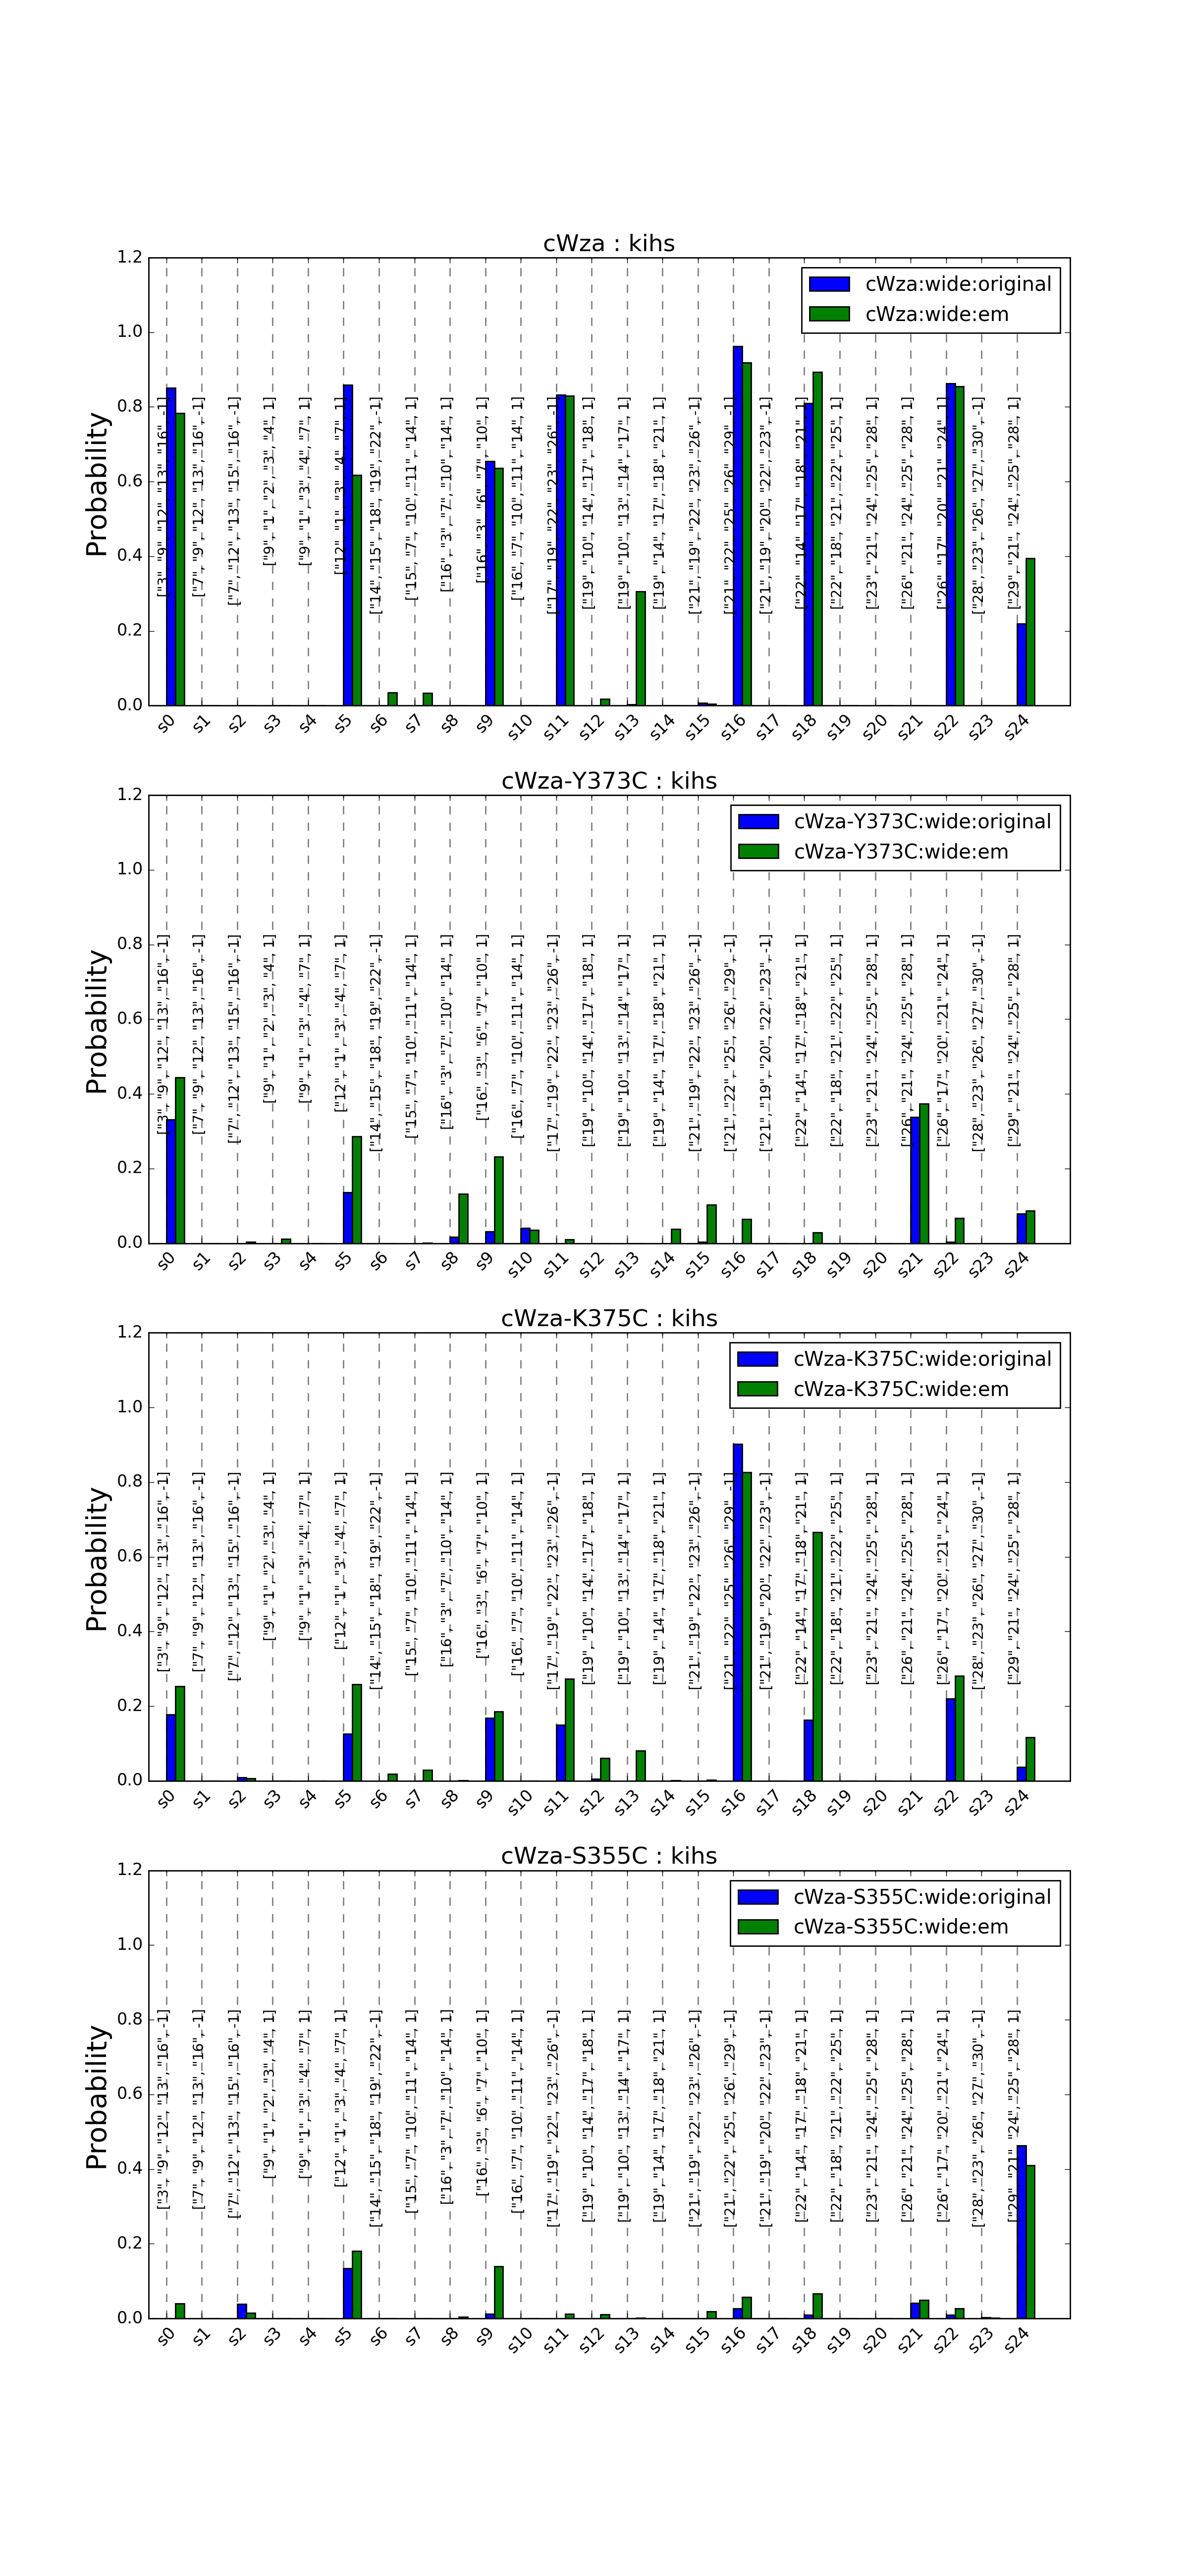

In [356]:
fig_hbonds,ax = plt.subplots(len(mutant_names),1,figsize=(12,26),dpi=200)

interaction_type = 'kihs'
X = numpy.arange(len(S_refined[interaction_type]))
data = probability_data_refined[interaction_type]

for i in range(len(mutant_names)):
    index0 = 4*i+2
    Y0 = data[index0]
    ax[i].bar(X, Y0,label=":".join(labels[interaction_type][index0]),width=0.25,color='blue')

    shift = 0.25
    index1 = index0+1
    Y1 = data[index1]
    ax[i].bar(X+shift, Y1,label=":".join(labels[interaction_type][index1]),width=0.25,color='green')
    
    ax[i].set_title(mutant_names[i]+" : "+interaction_type,fontsize=17)
    ax[i].set_xlim(-0.5,len(X)+0.5)
    ax[i].set_ylim(0,1.2)


    ax[i].set_xticks(X)
    ax[i].set_xticklabels(["s"+str(j) for j in range(len(X))],rotation=45)
    for k in range(len(X)):
        ax[i].plot((k,k),(0,1.2),color="black",linestyle="--",alpha=0.5)

    ax[i].set_ylabel("Probability",fontsize=20)
    
    for k in range(len(X)):
        ax[i].text(k-0.25,0.8,list(S_refined[interaction_type])[k],fontsize=10,rotation=90)

    ax[i].legend(loc="best")
        
plt.show()

<h1 style="text-align:center">Backbone-Assembly radius:</h1>
<h2 style="text-align:center">Docked Vs. Energy minimised models</h2>

In [389]:
def get_assembly_radius(file, rtype):
    try:
        # Convert to AMPAL
        p = isambard_dev.ampal.convert_pdb_to_ampal(file)
        # Number of chains
        n_chains = len(p.sequences)
        # Extract Complex and Chain COM data 
        if rtype == 'bb':
            ccom = p.backbone.centre_of_mass
            chains_com = [p[k].backbone.centre_of_mass for k in range(n_chains)]
        elif rtype == 'all' :
            ccom = p.centre_of_mass
            chains_com = [p[k].centre_of_mass for k in range(n_chains)]
        com_dd_distances = []
        for k in range(n_chains):
                com_dd_distances.append(numpy.linalg.norm(chains_com[k] - ccom))
        return com_dd_distances
    except:
        return 'NoFile'

In [491]:
mutant_models_info = {}
for i in range(len(mutant_names)):
    mutant_models_info[mutant_names[i]] = {}
    mutant_models_info[mutant_names[i]]['base_path'] = mutant_paths[i]
    mutant_models_info[mutant_names[i]]['groups'] = {}
    for group in ['narrow','wide']:
        path0 = mutant_paths[i]
        path = path0+'/'+group+'_pdbs.txt'
        pdbnames = [x.rstrip()[:-4] for x in open(path,'r').readlines()]
        mutant_models_info[mutant_names[i]]['groups'][group] = pdbnames

Save info in dictionary as JSON file

In [501]:
Path0 = '/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test'

with open(Path0+'/'+'mutant_models_info.json', 'w') as fp:
    json.dump(mutant_models_info, fp, sort_keys=True, indent=4)

In [ ]:
D = mutant_models_info

In [512]:
def extract_mutant_info(D):
    """Generate list of all info tags and paths for docked and em models"""
    tags = []
    path_names = []
    for mutant in list(D.keys()):
        for group in list(D[mutant]['groups'].keys()):
            for pdb in list(D[mutant]['groups'][group]):
                # Add tags 
                tags.append([mutant, group, pdb,'docked'])
                tags.append([mutant, group, pdb,'em'])
                # Add paths for model types
                path0 = D[mutant]['base_path']
                path_docked = path0+'/'+group+'/input/'+pdb
                path_em = path0+'/'+group+'/output/'+pdb+'/complex/em/em_20000stps'
                path_names.append(path_docked)
                path_names.append(path_em)
    return tags, path_names

In [570]:
tags, path_names = extract_mutant_info(D)

# Extract data from DB

In [3]:
path0 = '/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test'
dbfile = path0+'/'+'mutant_models_analysis.db'

In [5]:
new_module = path0
if new_module not in sys.path:
    sys.path.append(new_module)

Stuff to load database

In [90]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from setup_db import Json, Tags, Interhelix_Interactions, Complex_Radii, HOLE_Output, Base

In [94]:
engine = create_engine('sqlite:///'+dbfile)
Base.metadata.bind = engine
DBSession = sessionmaker()
DBSession.bind = engine
session = DBSession()

## Geometry of conformational groups

<IPython.core.display.Javascript object>


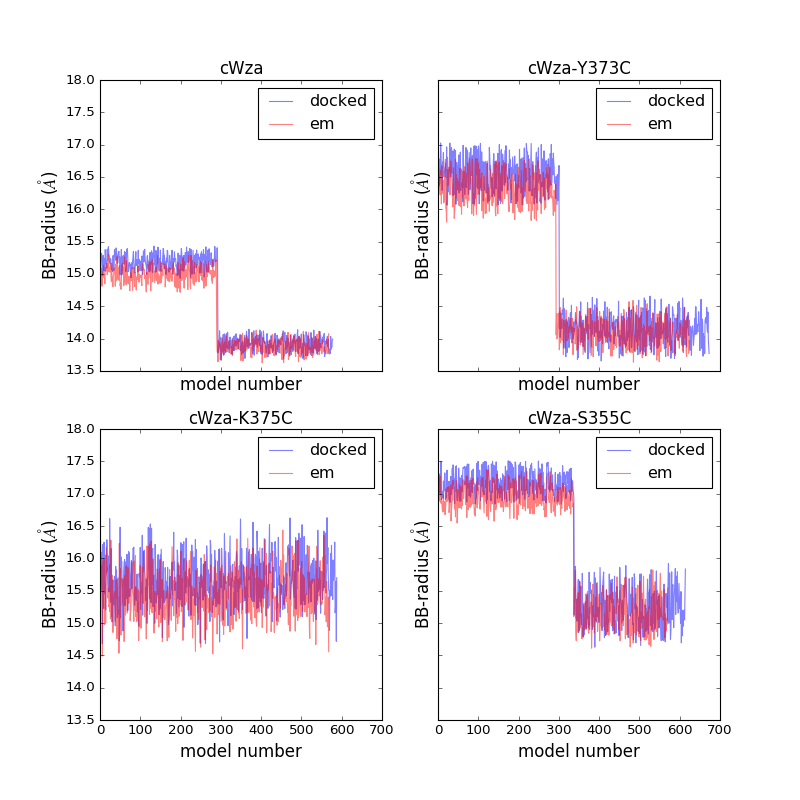

In [169]:
figg,ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

colors = {
    'docked':'blue',
    'em':'red'
}

axes = {
    'cWza':ax[0][0],
    'cWza-Y373C':ax[0][1],
    'cWza-K375C':ax[1][0],
    'cWza-S355C':ax[1][1]
}

for mutant in mutant_names:
    for model_type in ['docked','em']:
        model_ids = [x[0] for x in session.query(Tags.id).filter_by(model_type=model_type,mutant=mutant)]
        data = []
        for id in model_ids:
            try:
    #             r_type = Complex_Radii.scbb_radii
                r_type = Complex_Radii.bb_radii
                r_complex = session.query(r_type).filter_by(id = id).all()[0]
                data.append(numpy.mean(r_complex))
            except:
                pass

#         axes[mutant].plot(data,color=colors[model_type],marker='o',linestyle='',label=model_type,alpha=0.5)
        axes[mutant].plot(data,color=colors[model_type],label=model_type,alpha=0.5)
        axes[mutant].set_title(mutant,fontsize=15)
        axes[mutant].set_xlabel('model number',fontsize=15)
        axes[mutant].set_ylabel('BB-radius ($\AA$)',fontsize=15)
        axes[mutant].legend()

plt.show()


<IPython.core.display.Javascript object>


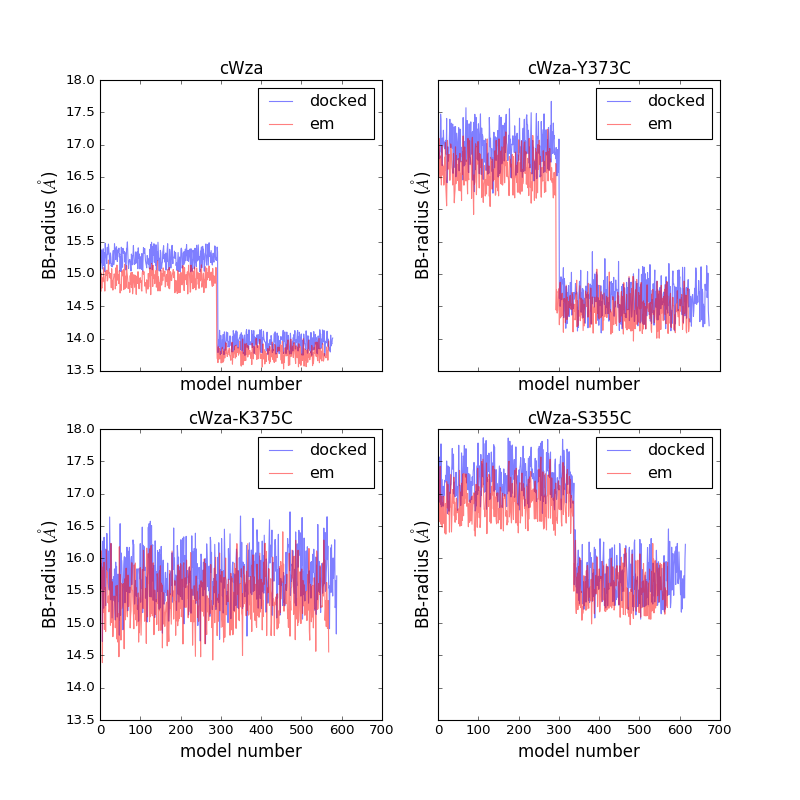

In [186]:
figg,ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

colors = {
    'docked':'blue',
    'em':'red'
}

axes = {
    'cWza':ax[0][0],
    'cWza-Y373C':ax[0][1],
    'cWza-K375C':ax[1][0],
    'cWza-S355C':ax[1][1]
}

for mutant in mutant_names:
    for model_type in ['docked','em']:
        model_ids = [x[0] for x in session.query(Tags.id).filter_by(model_type=model_type,mutant=mutant)]
        data = []
        for id in model_ids:
            try:
                r_type = Complex_Radii.scbb_radii
#                 r_type = Complex_Radii.bb_radii
                r_complex = session.query(r_type).filter_by(id = id).all()[0]
                data.append(numpy.mean(r_complex))
            except:
                pass

#         axes[mutant].plot(data,color=colors[model_type],marker='o',linestyle='',label=model_type,alpha=0.5)
        axes[mutant].plot(data,color=colors[model_type],label=model_type,alpha=0.5)
        axes[mutant].set_title(mutant,fontsize=15)
        axes[mutant].set_xlabel('model number',fontsize=15)
        axes[mutant].set_ylabel('BB-radius ($\AA$)',fontsize=15)
        axes[mutant].legend()

plt.show()


## Conductance

<IPython.core.display.Javascript object>


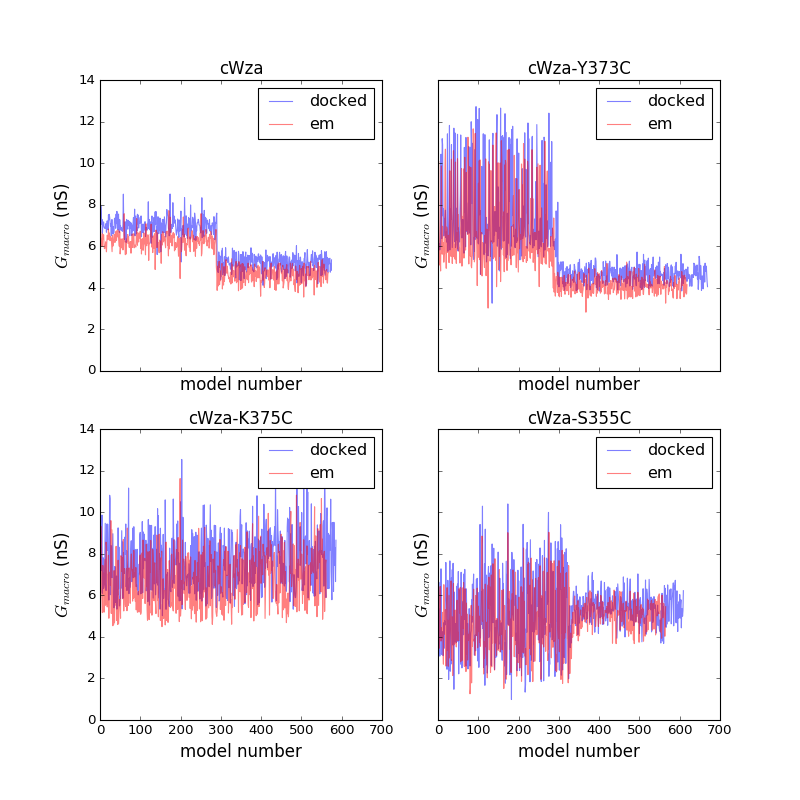

In [184]:
figg,ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

colors = {
    'docked':'blue',
    'em':'red'
}

axes = {
    'cWza':ax[0][0],
    'cWza-Y373C':ax[0][1],
    'cWza-K375C':ax[1][0],
    'cWza-S355C':ax[1][1]
}

for mutant in mutant_names:
    for model_type in ['docked','em']:
        model_ids = [x[0] for x in session.query(Tags.id).filter_by(model_type=model_type,mutant=mutant)]
        data = []
        for id in model_ids:
            try:
                HOLE_data = json.loads(session.query(HOLE_Output.HOLE_data).filter_by(id = id).first()[0])[1]
                data.append(HOLE_data[0])
            except:
                pass

#         axes[mutant].plot(data,color=colors[model_type],marker='o',linestyle='',label=model_type,alpha=0.5)
        axes[mutant].plot(data,color=colors[model_type],label=model_type,alpha=0.5)
        axes[mutant].set_title(mutant,fontsize=15)
        axes[mutant].set_xlabel('model number',fontsize=15)
        axes[mutant].set_ylabel('$G_{macro}$ (nS)',fontsize=15)
        axes[mutant].legend()

plt.show()


<IPython.core.display.Javascript object>


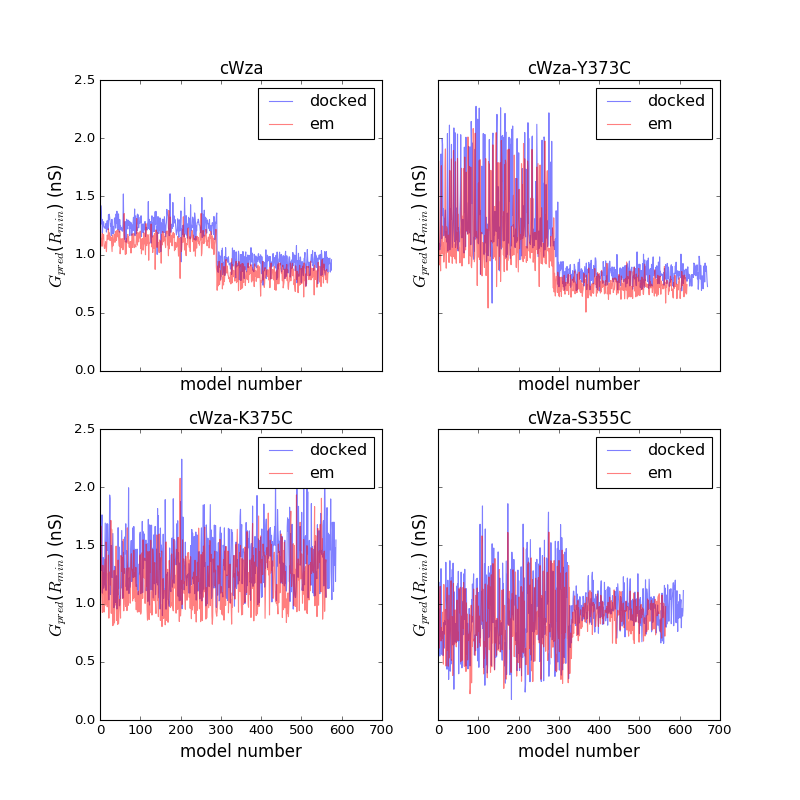

In [185]:
figg,ax = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

colors = {
    'docked':'blue',
    'em':'red'
}

axes = {
    'cWza':ax[0][0],
    'cWza-Y373C':ax[0][1],
    'cWza-K375C':ax[1][0],
    'cWza-S355C':ax[1][1]
}

for mutant in mutant_names:
    for model_type in ['docked','em']:
        model_ids = [x[0] for x in session.query(Tags.id).filter_by(model_type=model_type,mutant=mutant)]
        data = []
        for id in model_ids:
            try:
                HOLE_data = json.loads(session.query(HOLE_Output.HOLE_data).filter_by(id = id).first()[0])[1]
                data.append(HOLE_data[1])
            except:
                pass

#         axes[mutant].plot(data,color=colors[model_type],marker='o',linestyle='',label=model_type,alpha=0.5)
        axes[mutant].plot(data,color=colors[model_type],label=model_type,alpha=0.5)
        axes[mutant].set_title(mutant,fontsize=15)
        axes[mutant].set_xlabel('model number',fontsize=15)
        axes[mutant].set_ylabel('$G_{pred}$($R_{min}$) (nS)',fontsize=15)
        axes[mutant].legend()

plt.show()


**TO-DO**:

1. Analyse docked models from repetitions (different relaxed structures, master units, different mutants)
2. Submit repetitions if necessary
3. Submit MD jobs for narrow/wide models cWza (all), and few from other groups for other mutants
4. Contact Ali, Sesh, or someone else to discuss interpretation
5. Maybe submit docking/em for cWza-Y373A

## Analyse Pressure and Temp for PRMD files and also SC-interaction analysis

In [ ]:
sudo sshfs ba13026@bc4login.acrc.bris.ac.uk:/mnt/storage/scratch/ba13026/ ./bc4 -o allow_other  -o follow_symlinks
refined1_0001_INPUT_0935_ignorechain

# Peptide orientation

Test

In [2]:
path0 = "/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwza_NoWPN/3-analysis/md_relax/sem"

pdb = path0+'/narrow/input/refined1_0001_INPUT_0002_ignorechain.pdb'

p = isambard_dev.ampal.convert_pdb_to_ampal(pdb)

ampal = p
prims = numpy.array([x.coordinates for x in ampal.primitives])
ref_axis = isambard_dev.ampal.pseudo_atoms.Primitive.from_coordinates(
        numpy.mean(prims, axis=0))

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x,y,z = numpy.array(ref_axis.coordinates).T
ax.scatter(x,y,z)

for n in range(8):
    x,y,z = numpy.array(prims[n]).T
    ax.scatter(x,y,z,color='red',c='yellow')

ax.set_aspect('equal')
plt.show()

Plot reference axes from all dcoked models

In [47]:
def get_refaxis_prims(ampal):
    ampal = p
    prims = numpy.array([x.coordinates for x in ampal.primitives])
    ref_axis = isambard_dev.ampal.pseudo_atoms.Primitive.from_coordinates(
        numpy.mean(prims, axis=0))
    return ref_axis.coordinates, prims

<IPython.core.display.Javascript object>


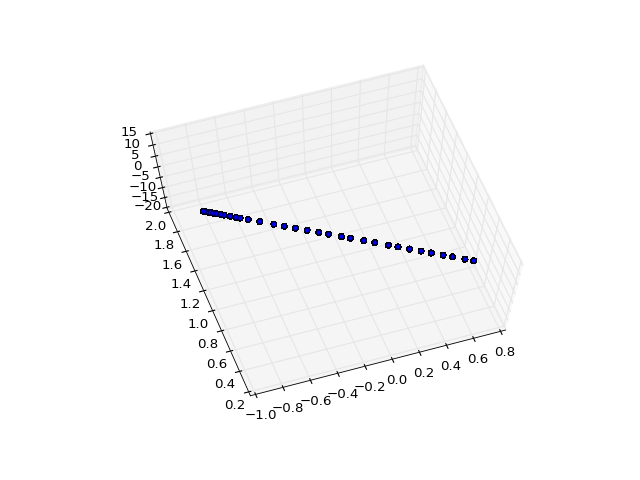

In [48]:
from mpl_toolkits.mplot3d import Axes3D
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')


for group in ['narrow','wide']:
    PDBs = [x.rstrip() for x in open(path0+'/'+group+'_pdbs.txt').readlines()]
    for pdb in PDBs:
        pdb_path = path0+'/'+group+'/input/'+pdb
        ampal = isambard_dev.ampal.convert_pdb_to_ampal(pdb_path)
        ref_axis, prims = get_refaxis_prims(ampal)
        x,y,z = numpy.array(ref_axis).T
        ax.scatter(x,y,z)
        

# x,y,z = numpy.array(ref_axis.coordinates).T
# ax.scatter(x,y,z)

# for n in range(8):
#     x,y,z = numpy.array(prims[n]).T
#     ax.scatter(x,y,z,color='red',c='yellow')

# ax.set_aspect('equal')
plt.show()